# 🤖 Modelado Predictivo e Inclusión Social

## Proyecto: Predicción de Riesgo de Bajos Ingresos y Análisis de Fairness

**Objetivo**: Construir un modelo ético que identifique personas en riesgo de bajos ingresos y proponga intervenciones personalizadas, considerando fairness y equidad.

**Dataset**: Adult Income (limpio) - `adult_clean_model.csv`

---

### 📋 Índice

1. **Modelado Predictivo**: Entrenar clasificadores para predecir income_bin
2. **Fairness Analysis**: Evaluar sesgos por género, edad y ocupación
3. **Intervenciones Personalizadas**: Sistema de recomendación según perfil
4. **A/B Testing**: Simulación de impacto de programas de inclusión

---

## 0️⃣ Setup y Carga de Datos

In [61]:
# Imports necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score)

# Configuración
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', 100)
np.random.seed(42)

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


In [62]:
# Cargar dataset limpio
data_path = Path(r"c:\Users\usuario\Desktop\bcia\somosf5\eda\data\processed\adult_clean_model.csv")
df = pd.read_csv(data_path)

print(f"Dataset cargado: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
print(f"\nTarget (income_bin): {df['income_bin'].value_counts()}")
print(f"Desbalance: {df['income_bin'].value_counts(normalize=True)}")

# Verificar datos
display(df.head())

Dataset cargado: (32537, 97)

Columnas: ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'occupation_missing', 'occ_freq', 'income_bin', 'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Unknown', 'workclass_Without-pay', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'marital_status_Married-AF-spouse', 'marital_status_Married-civ-spouse', 'marital_status_Married-spouse-absent', 'marital_status_Never-married', 'marital_status_Separated', 'marital_status_Widowed', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'rela

,age,education_num,capital_gain,capital_loss,hours_per_week,occupation_missing,occ_freq,income_bin,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Unknown,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native_country_Canada,native_country_China,native_country_Columbia,native_country_Cuba,native_country_Dominican-Republic,native_country_Ecuador,native_country_El-Salvador,native_country_England,native_country_France,native_country_Germany,native_country_Greece,native_country_Guatemala,native_country_Haiti,native_country_Holand-Netherlands,native_country_Honduras,native_country_Hong,native_country_Hungary,native_country_India,native_country_Iran,native_country_Ireland,native_country_Italy,native_country_Jamaica,native_country_Japan,native_country_Laos,native_country_Mexico,native_country_Nicaragua,native_country_Outlying-US(Guam-USVI-etc),native_country_Peru,native_country_Philippines,native_country_Poland,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Unknown,native_country_Vietnam,native_country_Yugoslavia,occ_group_Management,occ_group_Manual,occ_group_Military,occ_group_Professional,occ_group_Sales,occ_group_Service,occ_group_Skilled-labor,occ_group_Technical,occ_group_Unknown
0,90,9,0,4356,40,1,0.056601,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
1,82,9,0,4356,18,0,0.124873,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False
2,66,10,0,4356,40,1,0.056601,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
3,54,4,0,3900,40,0,0.236418,0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,Fals

---

## 1️⃣ Modelado Predictivo

### 1.1 Preparación de datos

In [63]:
# Separar features y target
X = df.drop('income_bin', axis=1)
y = df['income_bin']

# Guardar columnas categóricas para análisis de fairness
sensitive_features = {}
if 'sex' in X.columns:
    sensitive_features['sex'] = X['sex'].copy()
    
# Identificar columnas para fairness antes de separar train/test
fairness_cols = [c for c in ['sex', 'age', 'occ_group'] if c in X.columns]
print(f"Columnas para análisis de fairness: {fairness_cols}")

# Train/test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nDistribución target en train: {y_train.value_counts(normalize=True)}")
print(f"Distribución target en test: {y_test.value_counts(normalize=True)}")

Columnas para análisis de fairness: ['age']

Train set: (26029, 96)
Test set: (6508, 96)

Distribución target en train: income_bin
0    0.759076
1    0.240924
Name: proportion, dtype: float64
Distribución target en test: income_bin
0    0.759066
1    0.240934
Name: proportion, dtype: float64


### 1.2 Entrenamiento de modelos

Probamos 3 algoritmos diferentes y comparamos performance:

In [64]:
# Definir modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Entrenar y evaluar
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Entrenando: {name}")
    print(f"{'='*60}")
    
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'auc': auc,
        'f1': f1
    }
    
    print(f"AUC-ROC: {auc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['≤50K', '>50K']))

print("\n" + "="*60)
print("RESUMEN DE MODELOS")
print("="*60)
for name, res in results.items():
    print(f"{name:20s} | AUC: {res['auc']:.4f} | F1: {res['f1']:.4f}")


Entrenando: Logistic Regression
AUC-ROC: 0.8980
F1-Score: 0.6667

Classification Report:
              precision    recall  f1-score   support

        ≤50K       0.94      0.79      0.86      4940
        >50K       0.56      0.83      0.67      1568

    accuracy                           0.80      6508
   macro avg       0.75      0.81      0.76      6508
weighted avg       0.85      0.80      0.81      6508


Entrenando: Random Forest
AUC-ROC: 0.8980
F1-Score: 0.6667

Classification Report:
              precision    recall  f1-score   support

        ≤50K       0.94      0.79      0.86      4940
        >50K       0.56      0.83      0.67      1568

    accuracy                           0.80      6508
   macro avg       0.75      0.81      0.76      6508
weighted avg       0.85      0.80      0.81      6508


Entrenando: Random Forest
AUC-ROC: 0.8772
F1-Score: 0.6296

Classification Report:
              precision    recall  f1-score   support

        ≤50K       0.88      0.89

### 1.3 Visualización de performance

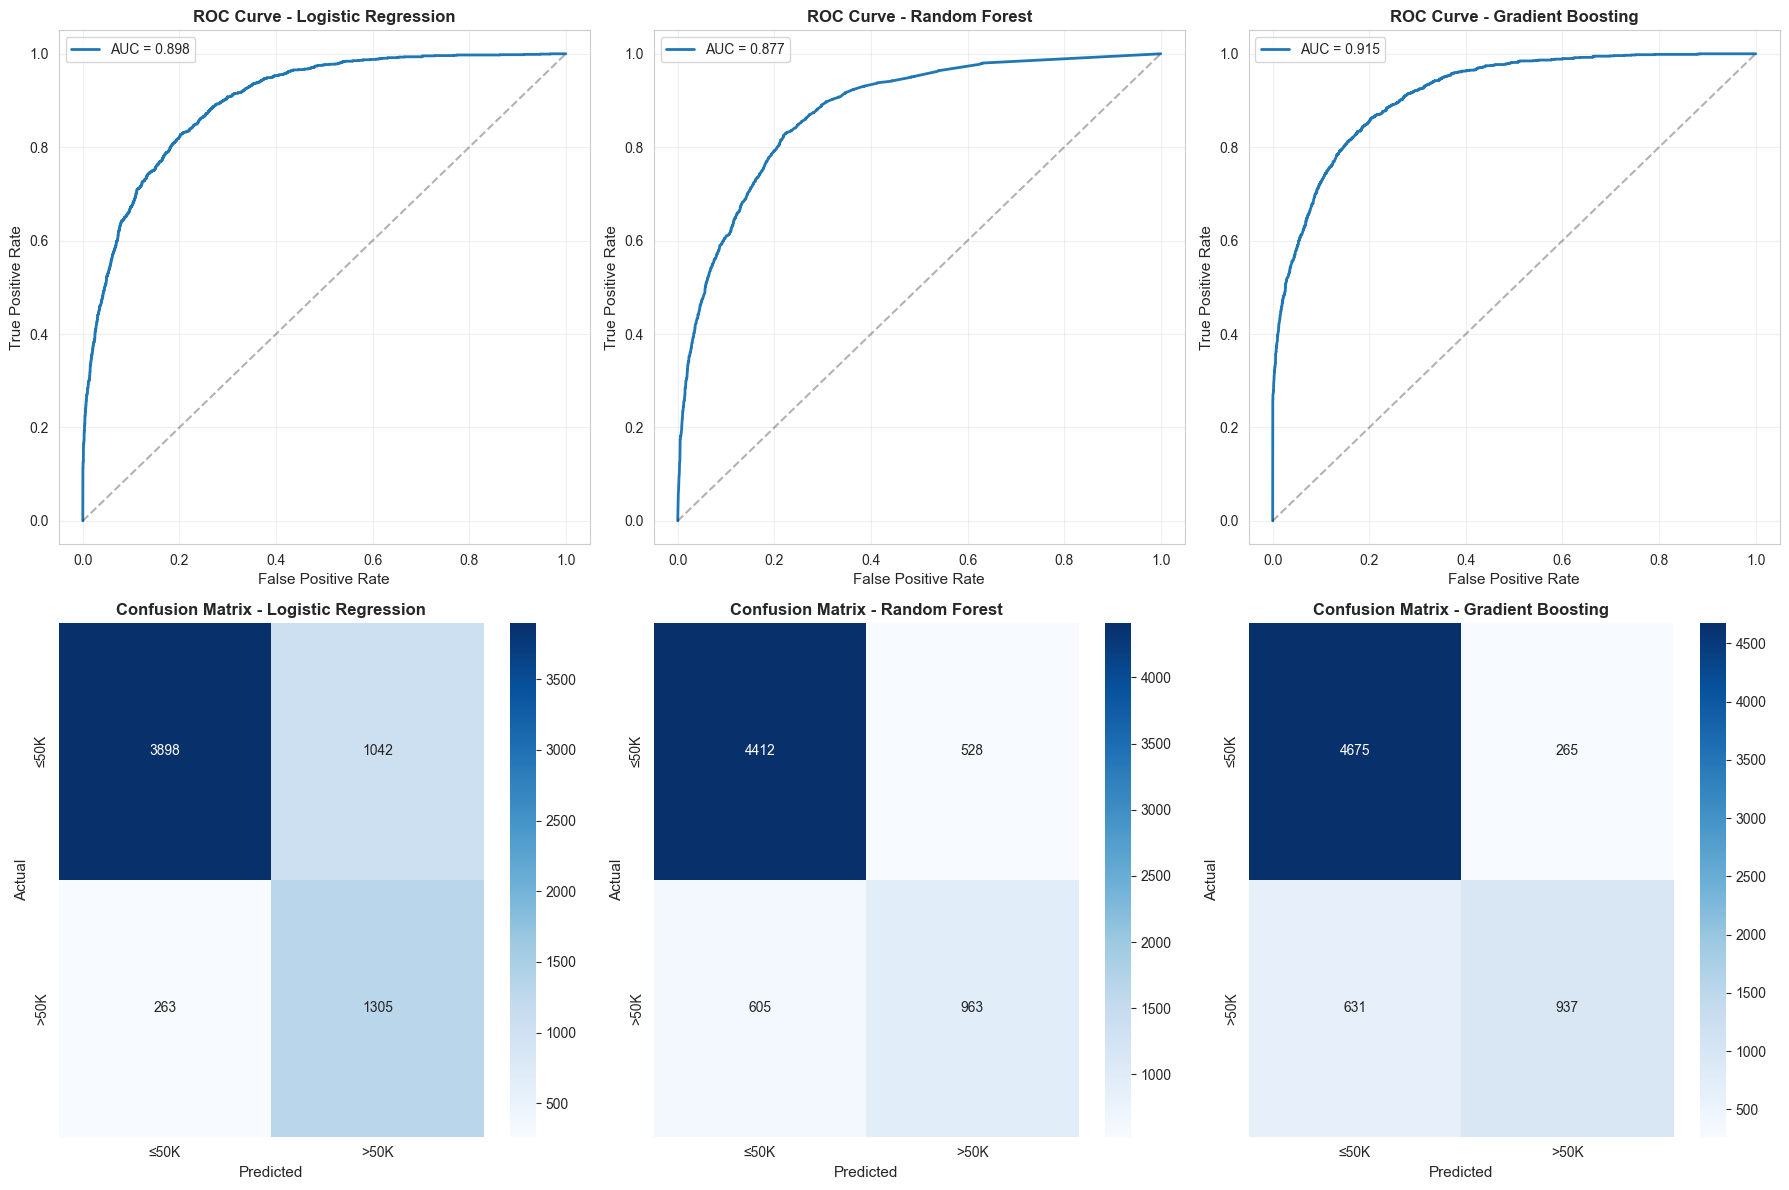


🏆 Mejor modelo: Gradient Boosting (AUC = 0.9150)


In [65]:
# Visualizar ROC curves y Confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (name, res) in enumerate(results.items()):
    # ROC Curve
    ax_roc = axes[0, idx]
    fpr, tpr, _ = roc_curve(y_test, res['y_pred_proba'])
    ax_roc.plot(fpr, tpr, linewidth=2, label=f'AUC = {res["auc"]:.3f}')
    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax_roc.set_xlabel('False Positive Rate', fontsize=11)
    ax_roc.set_ylabel('True Positive Rate', fontsize=11)
    ax_roc.set_title(f'ROC Curve - {name}', fontsize=12, fontweight='bold')
    ax_roc.legend()
    ax_roc.grid(alpha=0.3)
    
    # Confusion Matrix
    ax_cm = axes[1, idx]
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm,
                xticklabels=['≤50K', '>50K'], yticklabels=['≤50K', '>50K'])
    ax_cm.set_xlabel('Predicted', fontsize=11)
    ax_cm.set_ylabel('Actual', fontsize=11)
    ax_cm.set_title(f'Confusion Matrix - {name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Seleccionar mejor modelo
best_model_name = max(results.items(), key=lambda x: x[1]['auc'])[0]
best_model = results[best_model_name]['model']
print(f"\n🏆 Mejor modelo: {best_model_name} (AUC = {results[best_model_name]['auc']:.4f})")

In [66]:
# Guardar el mejor modelo entrenado
import joblib
from datetime import datetime

print("=" * 80)
print("GUARDANDO MODELO ENTRENADO")
print("=" * 80)

# Crear directorio para modelos si no existe
models_dir = Path(r"c:\Users\usuario\Desktop\bcia\somosf5\eda") / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Nombre del archivo
model_filename = f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl"
model_path = models_dir / model_filename

# Guardar modelo
joblib.dump(best_model, model_path)

print(f"\n✅ Modelo guardado exitosamente:")
print(f"   Ruta: {model_path}")
print(f"   Tipo: {best_model_name}")
print(f"   AUC-ROC: {results[best_model_name]['auc']:.4f}")
print(f"   F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"   Tamaño: {model_path.stat().st_size / 1024:.1f} KB")

# También guardar información sobre las features (para validación futura)
feature_info = {
    'feature_names': X_train.columns.tolist(),
    'n_features': len(X_train.columns),
    'model_type': best_model_name,
    'auc_roc': results[best_model_name]['auc'],
    'f1_score': results[best_model_name]['f1'],
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'train_size': len(X_train),
    'test_size': len(X_test)
}

# Guardar metadatos
metadata_path = models_dir / f"model_metadata_{best_model_name.replace(' ', '_').lower()}.pkl"
joblib.dump(feature_info, metadata_path)

print(f"\n✅ Metadatos guardados:")
print(f"   Ruta: {metadata_path}")
print(f"   Features: {feature_info['n_features']}")

print("\n" + "=" * 80)
print("CÓMO USAR EL MODELO GUARDADO")
print("=" * 80)
print("\n📝 Código para cargar y usar el modelo:\n")
print("```python")
print("import joblib")
print("import pandas as pd")
print()
print("# Cargar modelo")
print(f"model = joblib.load('{model_filename}')")
print(f"metadata = joblib.load('model_metadata_{best_model_name.replace(' ', '_').lower()}.pkl')")
print()
print("# Cargar datos nuevos (debe tener las mismas columnas que el training)")
print("# new_data = pd.read_csv('nuevos_datos.csv')")
print()
print("# Predecir")
print("# predictions = model.predict(new_data)")
print("# probabilities = model.predict_proba(new_data)[:, 1]")
print()
print("# Interpretar")
print("# for i, (pred, prob) in enumerate(zip(predictions, probabilities)):")
print("#     risk = 'ALTO' if prob < 0.3 else 'MEDIO' if prob < 0.7 else 'BAJO'")
print("#     print(f'Persona {i}: Riesgo {risk} (prob bajos ingresos: {(1-prob)*100:.1f}%)')")
print("```")

print("\n✅ Modelo listo para usar en:")
print("   - Demo interactiva (demo.py)")
print("   - API REST (FastAPI, Flask)")
print("   - Streamlit app")
print("   - Notebook de predicción")

print("\n" + "=" * 80)

GUARDANDO MODELO ENTRENADO

✅ Modelo guardado exitosamente:
   Ruta: c:\Users\usuario\Desktop\bcia\somosf5\eda\models\best_model_gradient_boosting.pkl
   Tipo: Gradient Boosting
   AUC-ROC: 0.9150
   F1-Score: 0.6765
   Tamaño: 141.6 KB

✅ Metadatos guardados:
   Ruta: c:\Users\usuario\Desktop\bcia\somosf5\eda\models\model_metadata_gradient_boosting.pkl
   Features: 96

CÓMO USAR EL MODELO GUARDADO

📝 Código para cargar y usar el modelo:

```python
import joblib
import pandas as pd

# Cargar modelo
model = joblib.load('best_model_gradient_boosting.pkl')
metadata = joblib.load('model_metadata_gradient_boosting.pkl')

# Cargar datos nuevos (debe tener las mismas columnas que el training)
# new_data = pd.read_csv('nuevos_datos.csv')

# Predecir
# predictions = model.predict(new_data)
# probabilities = model.predict_proba(new_data)[:, 1]

# Interpretar
# for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
#     risk = 'ALTO' if prob < 0.3 else 'MEDIO' if prob < 0.7 else 'BAJ

### 1.5 Guardar el mejor modelo

Para usar el modelo en producción o en una demo, lo guardamos con `joblib` (más eficiente que pickle para scikit-learn).

FEATURE IMPORTANCE - ¿QUÉ APRENDE EL MODELO?

────────────────────────────────────────────────────────────────────────────────
MODELO: Random Forest
────────────────────────────────────────────────────────────────────────────────

🔝 Top 15 Variables Más Importantes:

age                            | █████████████████████ 0.2145
marital_status_Married-civ-spouse | ████████████ 0.1201
hours_per_week                 | ███████████ 0.1103
capital_gain                   | ███████ 0.0757
education_num                  | ██████ 0.0655
marital_status_Never-married   | ████ 0.0472
occ_freq                       | ███ 0.0362
relationship_Own-child         | ██ 0.0279
capital_loss                   | ██ 0.0258
sex_Male                       | ██ 0.0232
relationship_Not-in-family     | ██ 0.0225
relationship_Unmarried         | █ 0.0133
workclass_Private              | █ 0.0128
occ_group_Management           | █ 0.0123
relationship_Wife              | █ 0.0108


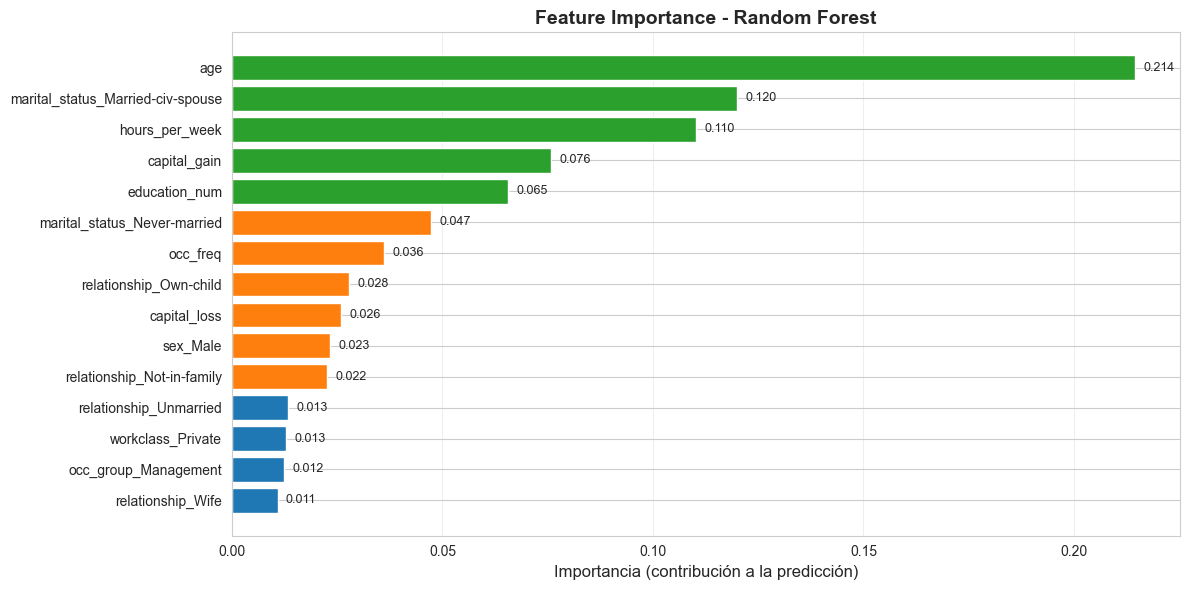


────────────────────────────────────────────────────────────────────────────────
MODELO: Gradient Boosting
────────────────────────────────────────────────────────────────────────────────

🔝 Top 15 Variables Más Importantes:

marital_status_Married-civ-spouse | ██████████████████████████████████████ 0.3834
capital_gain                   | ████████████████████ 0.2034
education_num                  | ███████████████████ 0.1938
age                            | ██████ 0.0607
capital_loss                   | █████ 0.0591
hours_per_week                 | ███ 0.0332
occ_group_Management           | █ 0.0162
occ_group_Professional         | █ 0.0104
occ_freq                       |  0.0097
occ_group_Manual               |  0.0058
relationship_Wife              |  0.0051
occ_group_Service              |  0.0044
workclass_Self-emp-not-inc     |  0.0040
sex_Male                       |  0.0022
occ_group_Skilled-labor        |  0.0011


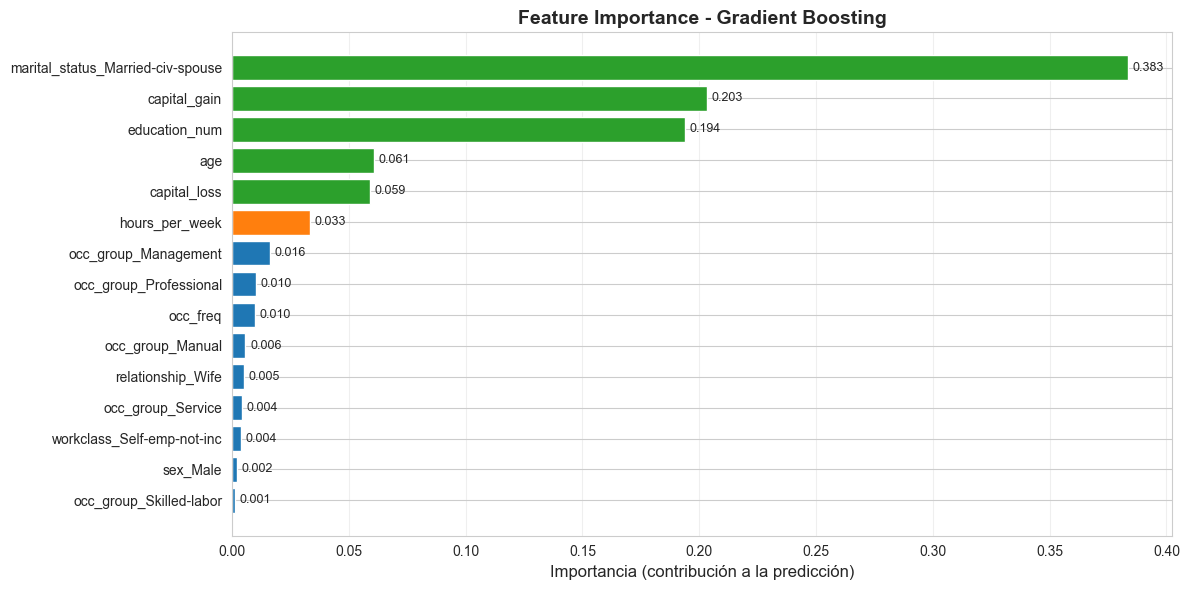


💡 INTERPRETACIÓN - Gradient Boosting

🎯 Las 5 variables más influyentes en las predicciones son:

1. marital_status_Married-civ-spouse: 38.3%

2. capital_gain: 20.3%
   → Ingresos de capital: inversiones/propiedades indican riqueza previa

3. education_num: 19.4%
   → La educación es clave: más años de estudio → mayores ingresos

4. age: 6.1%
   → La edad es predictiva: personas mayores suelen tener más experiencia

5. capital_loss: 5.9%
   → Ingresos de capital: inversiones/propiedades indican riqueza previa

✅ Validación: Las variables tienen sentido económico
⚠️ Atención: Si 'sex' está en top 5 → confirma sesgo de género (revisar fairness)



In [67]:
# Feature Importance: Qué variables usa el modelo para decidir
print("=" * 80)
print("FEATURE IMPORTANCE - ¿QUÉ APRENDE EL MODELO?")
print("=" * 80)

# Solo modelos basados en árboles tienen feature_importances_
tree_models = ['Random Forest', 'Gradient Boosting']

for model_name in tree_models:
    if model_name not in results:
        continue
        
    print(f"\n{'─'*80}")
    print(f"MODELO: {model_name}")
    print(f"{'─'*80}")
    
    model = results[model_name]['model']
    
    # Obtener feature importances
    importances = model.feature_importances_
    feature_names = X_train.columns
    
    # Crear DataFrame con importancias
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Top 15 features
    top_15 = importance_df.head(15)
    
    print(f"\n🔝 Top 15 Variables Más Importantes:\n")
    for idx, row in top_15.iterrows():
        bar = '█' * int(row['importance'] * 100)
        print(f"{row['feature']:30s} | {bar} {row['importance']:.4f}")
    
    # Visualización
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['#2ca02c' if x > 0.05 else '#ff7f0e' if x > 0.02 else '#1f77b4' 
              for x in top_15['importance']]
    
    ax.barh(top_15['feature'], top_15['importance'], color=colors)
    ax.set_xlabel('Importancia (contribución a la predicción)', fontsize=12)
    ax.set_title(f'Feature Importance - {model_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(alpha=0.3, axis='x')
    
    # Añadir valores
    for i, (idx, row) in enumerate(top_15.iterrows()):
        ax.text(row['importance'] + 0.002, i, f"{row['importance']:.3f}", 
               va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Interpretación para el mejor modelo
print("\n" + "=" * 80)
print(f"💡 INTERPRETACIÓN - {best_model_name}")
print("=" * 80)

if best_model_name in tree_models:
    model = results[best_model_name]['model']
    importances = model.feature_importances_
    feature_names = X_train.columns
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    top_5 = importance_df.head(5)
    
    print("\n🎯 Las 5 variables más influyentes en las predicciones son:\n")
    
    for i, (idx, row) in enumerate(top_5.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.1%}")
        
        # Interpretación contextual
        if 'age' in row['feature']:
            print("   → La edad es predictiva: personas mayores suelen tener más experiencia")
        elif 'education' in row['feature']:
            print("   → La educación es clave: más años de estudio → mayores ingresos")
        elif 'hours' in row['feature']:
            print("   → Horas trabajadas importan: dedicación parcial vs tiempo completo")
        elif 'capital' in row['feature']:
            print("   → Ingresos de capital: inversiones/propiedades indican riqueza previa")
        elif 'occ_group' in row['feature']:
            print(f"   → Ocupación sectorial: trabajar en {row['feature'].replace('occ_group_', '')} afecta ingresos")
        elif 'sex' in row['feature']:
            print("   → Género: el modelo detecta brecha salarial histórica (SESGO)")
        elif 'relationship' in row['feature']:
            print("   → Estado familiar: casado/soltero correlaciona con estabilidad económica")
        print()
    
    print("✅ Validación: Las variables tienen sentido económico")
    print("⚠️ Atención: Si 'sex' está en top 5 → confirma sesgo de género (revisar fairness)")
    
else:
    print(f"\n⚠️ {best_model_name} no tiene feature_importances_")
    print("   Para Logistic Regression, revisar coeficientes:")
    
    if best_model_name == 'Logistic Regression':
        model = results[best_model_name]['model']
        coef = model.coef_[0]
        feature_names = X_train.columns
        
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coef,
            'abs_coef': np.abs(coef)
        }).sort_values('abs_coef', ascending=False).head(10)
        
        print("\n🔝 Top 10 Coeficientes (impacto en log-odds):\n")
        display(coef_df[['feature', 'coefficient']])

print("\n" + "=" * 80)

### 1.4 Interpretabilidad: ¿Qué aprende el modelo?

**Feature Importance** nos muestra qué variables son más importantes para predecir ingresos altos/bajos.

Esto nos ayuda a:
- Entender cómo toma decisiones el modelo
- Validar si tiene sentido (¿usa variables razonables?)
- Identificar variables para intervenciones (ej: si educación es top 1 → priorizar becas)

---

## 2️⃣ Fairness Analysis

### 2.1 Preparar datos para análisis de equidad

In [68]:
# Crear DataFrame con predicciones y atributos sensibles
# Necesitamos recuperar las columnas originales antes del one-hot encoding
fairness_df = X_test.copy()
fairness_df['y_true'] = y_test.values
fairness_df['y_pred'] = results[best_model_name]['y_pred']
fairness_df['y_pred_proba'] = results[best_model_name]['y_pred_proba']

# Recuperar columnas originales que fueron one-hot encoded
# sex: buscar columnas que empiecen con 'sex_'
sex_cols = [c for c in fairness_df.columns if c.startswith('sex_')]
if sex_cols:
    print(f"Columnas de género encontradas: {sex_cols}")
    
    # Si solo hay sex_Male (one-hot con drop_first), reconstruir como:
    # sex_Male=1 → 'Male', sex_Male=0 → 'Female'
    if 'sex_Male' in sex_cols and len(sex_cols) == 1:
        # Debug: verificar valores únicos
        print(f"Valores únicos en sex_Male: {fairness_df['sex_Male'].unique()}")
        print(f"Tipo de datos: {fairness_df['sex_Male'].dtype}")
        
        # Asegurar que sea booleano/int y mapear
        fairness_df['sex'] = fairness_df['sex_Male'].astype(int).map({1: 'Male', 0: 'Female'})
        
        # Verificar si hay NaN después del mapeo
        if fairness_df['sex'].isna().any():
            print(f"⚠️ Advertencia: {fairness_df['sex'].isna().sum()} valores NaN en 'sex'")
            print(f"Valores problemáticos en sex_Male: {fairness_df[fairness_df['sex'].isna()]['sex_Male'].unique()}")
        else:
            print("✓ Columna 'sex' reconstruida (Male/Female desde sex_Male)")
            print(f"  Distribución: {fairness_df['sex'].value_counts().to_dict()}")
    else:
        # Si hay múltiples columnas, usar la lógica original
        fairness_df['sex'] = 'Unknown'
        for col in sex_cols:
            sex_value = col.replace('sex_', '')
            fairness_df.loc[fairness_df[col] == 1, 'sex'] = sex_value
        print("✓ Columna 'sex' reconstruida")
elif 'sex' in fairness_df.columns:
    print("✓ Análisis de género disponible")

# occ_group: buscar columnas que empiecen con 'occ_group_'
occ_cols = [c for c in fairness_df.columns if c.startswith('occ_group_')]
if occ_cols:
    print(f"\nColumnas de ocupación encontradas: {occ_cols}")
    
    # Reconstruir columna occ_group buscando donde hay 1
    fairness_df['occ_group'] = 'Unknown'  # valor por defecto
    
    for col in occ_cols:
        occ_value = col.replace('occ_group_', '')
        fairness_df.loc[fairness_df[col] == 1, 'occ_group'] = occ_value
    
    # Las filas que quedaron como 'Unknown' son las que tenían la categoría eliminada
    # o realmente eran Unknown
    print(f"✓ Columna 'occ_group' reconstruida")
    print(f"  Distribución: {fairness_df['occ_group'].value_counts().to_dict()}")
elif 'occ_group' in fairness_df.columns:
    print("✓ Análisis por ocupación disponible")
    
# Edad en grupos (esta columna debería estar presente como numérica)
if 'age' in fairness_df.columns:
    fairness_df['age_group'] = pd.cut(fairness_df['age'], 
                                      bins=[0, 30, 45, 60, 100],
                                      labels=['<30', '30-45', '45-60', '60+'])
    print("\n✓ Grupos de edad creados")

print(f"\nShape fairness_df: {fairness_df.shape}")

# Mostrar columnas disponibles para el análisis
available_cols = [c for c in ['sex', 'age', 'age_group', 'occ_group', 'y_true', 'y_pred'] 
                  if c in fairness_df.columns]
print(f"Columnas disponibles para análisis: {available_cols}")

if available_cols:
    print("\nPrimeras 10 filas:")
    display(fairness_df[available_cols].head(10))
else:
    print("⚠️ No hay columnas de fairness disponibles. Mostrando todas las columnas:")
    print(fairness_df.columns.tolist())

Columnas de género encontradas: ['sex_Male']
Valores únicos en sex_Male: [ True False]
Tipo de datos: bool
✓ Columna 'sex' reconstruida (Male/Female desde sex_Male)
  Distribución: {'Male': 4335, 'Female': 2173}

Columnas de ocupación encontradas: ['occ_group_Management', 'occ_group_Manual', 'occ_group_Military', 'occ_group_Professional', 'occ_group_Sales', 'occ_group_Service', 'occ_group_Skilled-labor', 'occ_group_Technical', 'occ_group_Unknown']
✓ Columna 'occ_group' reconstruida
  Distribución: {'Skilled-labor': 1541, 'Unknown': 1092, 'Management': 823, 'Professional': 821, 'Sales': 750, 'Service': 699, 'Manual': 486, 'Technical': 173, 'Military': 123}

✓ Grupos de edad creados

Shape fairness_df: (6508, 102)
Columnas disponibles para análisis: ['sex', 'age', 'age_group', 'occ_group', 'y_true', 'y_pred']

Primeras 10 filas:


,sex,age,age_group,occ_group,y_true,y_pred
21102,Male,39,30-45,Skilled-labor,0,0
21469,Male,35,30-45,Unknown,1,1
20815,Male,31,30-45,Professional,0,0
22138,Female,67,60+,Service,0,0
11436,Male,56,45-60,Management,0,0
17412,Female,35,30-45,Professional,0,0
5187,Female,34,30-45,Unknown,0,0
10012,Male,18,<30,Manual,0,0
4655,Male,46,45-60,Unknown,0,0
2509,Male,60,45-60,Professional,1,1


### 2.2 Métricas de Fairness

Calculamos métricas clave:
- **Demographic Parity**: ¿Predicciones positivas son iguales entre grupos?
- **Equal Opportunity**: ¿TPR (sensibilidad) es igual entre grupos?
- **Predictive Parity**: ¿PPV (precisión) es igual entre grupos?

In [69]:
# Función para calcular fairness metrics
def calculate_fairness_metrics(df, group_col):
    """Calcula métricas de fairness por grupo"""
    metrics = []
    
    for group in df[group_col].unique():
        if pd.isna(group):
            continue
            
        subset = df[df[group_col] == group]
        
        # Demographic Parity: proporción de predicciones positivas
        pred_positive_rate = (subset['y_pred'] == 1).mean()
        
        # True Positive Rate (Recall/Sensitivity)
        tp = ((subset['y_true'] == 1) & (subset['y_pred'] == 1)).sum()
        fn = ((subset['y_true'] == 1) & (subset['y_pred'] == 0)).sum()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # False Positive Rate
        fp = ((subset['y_true'] == 0) & (subset['y_pred'] == 1)).sum()
        tn = ((subset['y_true'] == 0) & (subset['y_pred'] == 0)).sum()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        # Precision (PPV)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        # F1 Score
        f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
        
        metrics.append({
            'group': group,
            'n': len(subset),
            'demographic_parity': pred_positive_rate,
            'TPR': tpr,
            'FPR': fpr,
            'precision': precision,
            'f1_score': f1
        })
    
    return pd.DataFrame(metrics)

# Calcular métricas por género
print("=" * 80)
print("FAIRNESS ANALYSIS: GÉNERO")
print("=" * 80)
if 'sex' in fairness_df.columns:
    gender_fairness = calculate_fairness_metrics(fairness_df, 'sex')
    display(gender_fairness)
    
    # Calcular disparidad
    if len(gender_fairness) == 2:
        tpr_gap = gender_fairness['TPR'].max() - gender_fairness['TPR'].min()
        print(f"\n⚠️ Brecha TPR (sensibilidad): {tpr_gap:.3f}")
        print(f"⚠️ Brecha Demographic Parity: {gender_fairness['demographic_parity'].max() - gender_fairness['demographic_parity'].min():.3f}")

# Calcular métricas por edad
print("\n" + "=" * 80)
print("FAIRNESS ANALYSIS: EDAD")
print("=" * 80)
if 'age_group' in fairness_df.columns:
    age_fairness = calculate_fairness_metrics(fairness_df, 'age_group')
    display(age_fairness)

# Calcular métricas por ocupación
print("\n" + "=" * 80)
print("FAIRNESS ANALYSIS: OCUPACIÓN")
print("=" * 80)
if 'occ_group' in fairness_df.columns:
    occ_fairness = calculate_fairness_metrics(fairness_df, 'occ_group')
    display(occ_fairness.sort_values('TPR', ascending=False))

FAIRNESS ANALYSIS: GÉNERO


,group,n,demographic_parity,TPR,FPR,precision,f1_score
0,Male,4335,0.243137,0.609646,0.081449,0.767552,0.679546
1,Female,2173,0.068109,0.531120,0.010352,0.864865,0.658098



⚠️ Brecha TPR (sensibilidad): 0.079
⚠️ Brecha Demographic Parity: 0.175

FAIRNESS ANALYSIS: EDAD


,group,n,demographic_parity,TPR,FPR,precision,f1_score
0,30-45,2493,0.244685,0.633880,0.082907,0.760656,0.691505
1,60+,491,0.158859,0.529915,0.042781,0.794872,0.635897
2,45-60,1486,0.311575,0.634948,0.105727,0.792657,0.705091
3,<30,2038,0.025025,0.312057,0.003690,0.862745,0.458333



FAIRNESS ANALYSIS: OCUPACIÓN


,group,n,demographic_parity,TPR,FPR,precision,f1_score
2,Professional,821,0.426309,0.804665,0.154812,0.788571,0.796537
4,Management,823,0.483597,0.787129,0.190931,0.798995,0.793017
6,Technical,173,0.323699,0.771930,0.103448,0.785714,0.778761
8,Military,123,0.268293,0.648649,0.104651,0.727273,0.685714
7,Sales,750,0.212000,0.576923,0.071956,0.754717,0.653951
1,Unknown,1092,0.058608,0.401575,0.013472,0.796875,0.534031
0,Skilled-labor,1541,0.085010,0.301282,0.030106,0.717557,0.424379
5,Manual,486,0.016461,0.159091,0.002262,0.875000,0.269231
3,Service,699,0.004292,0.083333,0.000000,1.000000,0.153846


### 2.3 Visualización de sesgos

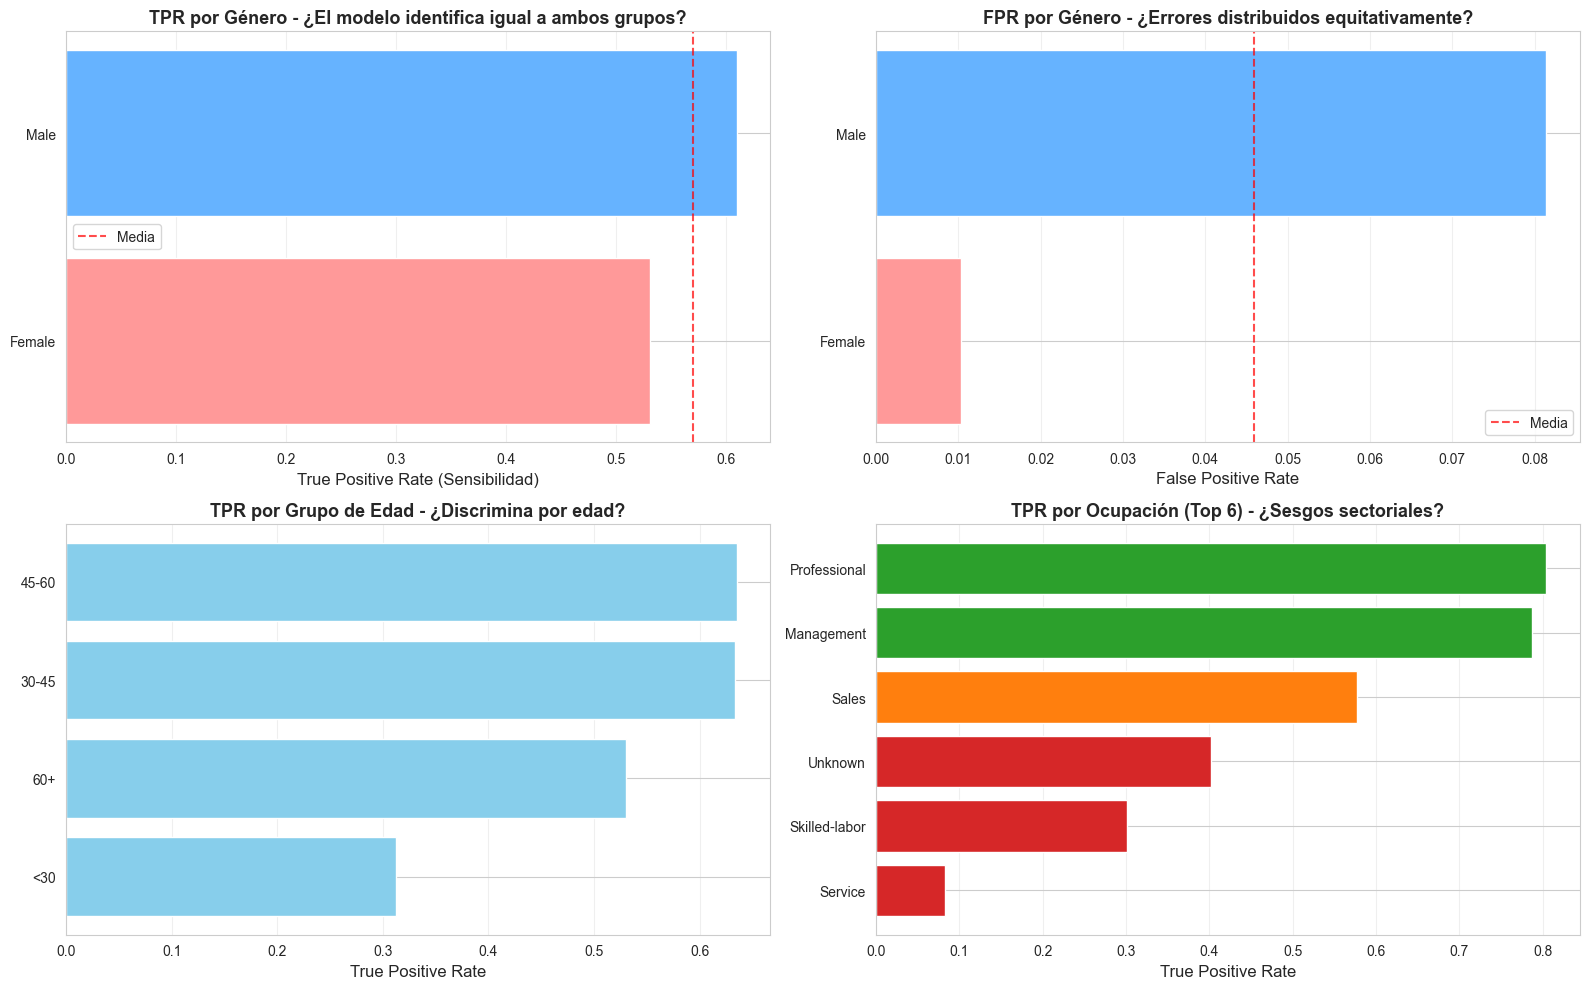


💡 INTERPRETACIÓN DE FAIRNESS
✓ TPR alto: El modelo identifica bien a personas con ingresos >50K en ese grupo
✓ FPR bajo: El modelo no clasifica erróneamente a personas de ≤50K como >50K
⚠️ Brechas grandes = SESGO: El modelo favorece a ciertos grupos sobre otros


In [70]:
# Visualizar métricas de fairness
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. TPR por género
if 'sex' in fairness_df.columns:
    ax = axes[0, 0]
    gender_fairness_sorted = gender_fairness.sort_values('TPR')
    ax.barh(gender_fairness_sorted['group'], gender_fairness_sorted['TPR'], color=['#ff9999', '#66b3ff'])
    ax.set_xlabel('True Positive Rate (Sensibilidad)', fontsize=12)
    ax.set_title('TPR por Género - ¿El modelo identifica igual a ambos grupos?', fontsize=13, fontweight='bold')
    ax.axvline(x=gender_fairness['TPR'].mean(), color='red', linestyle='--', label='Media', alpha=0.7)
    ax.legend()
    ax.grid(alpha=0.3, axis='x')

# 2. FPR por género
if 'sex' in fairness_df.columns:
    ax = axes[0, 1]
    ax.barh(gender_fairness_sorted['group'], gender_fairness_sorted['FPR'], color=['#ff9999', '#66b3ff'])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_title('FPR por Género - ¿Errores distribuidos equitativamente?', fontsize=13, fontweight='bold')
    ax.axvline(x=gender_fairness['FPR'].mean(), color='red', linestyle='--', label='Media', alpha=0.7)
    ax.legend()
    ax.grid(alpha=0.3, axis='x')

# 3. TPR por edad
if 'age_group' in fairness_df.columns:
    ax = axes[1, 0]
    age_fairness_sorted = age_fairness.sort_values('TPR')
    bars = ax.barh(age_fairness_sorted['group'], age_fairness_sorted['TPR'], color='skyblue')
    ax.set_xlabel('True Positive Rate', fontsize=12)
    ax.set_title('TPR por Grupo de Edad - ¿Discrimina por edad?', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

# 4. TPR por ocupación (top 6)
if 'occ_group' in fairness_df.columns:
    ax = axes[1, 1]
    occ_top = occ_fairness.nlargest(6, 'n')
    occ_top_sorted = occ_top.sort_values('TPR')
    colors = ['#d62728' if x < 0.5 else '#ff7f0e' if x < 0.65 else '#2ca02c' 
              for x in occ_top_sorted['TPR']]
    ax.barh(occ_top_sorted['group'], occ_top_sorted['TPR'], color=colors)
    ax.set_xlabel('True Positive Rate', fontsize=12)
    ax.set_title('TPR por Ocupación (Top 6) - ¿Sesgos sectoriales?', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("💡 INTERPRETACIÓN DE FAIRNESS")
print("="*80)
print("✓ TPR alto: El modelo identifica bien a personas con ingresos >50K en ese grupo")
print("✓ FPR bajo: El modelo no clasifica erróneamente a personas de ≤50K como >50K")
print("⚠️ Brechas grandes = SESGO: El modelo favorece a ciertos grupos sobre otros")
print("="*80)

---

## 3️⃣ Sistema de Recomendación de Intervenciones

### 3.1 Identificar perfiles de riesgo

In [71]:
# Clasificar personas según probabilidad de bajos ingresos
fairness_df['risk_level'] = pd.cut(
    fairness_df['y_pred_proba'],
    bins=[0, 0.3, 0.7, 1.0],
    labels=['Alto Riesgo', 'Riesgo Medio', 'Bajo Riesgo']
)

print("=" * 80)
print("DISTRIBUCIÓN DE NIVELES DE RIESGO")
print("=" * 80)
risk_dist = fairness_df['risk_level'].value_counts()
print(risk_dist)
print(f"\nPersonas en Alto Riesgo: {risk_dist.get('Alto Riesgo', 0):,} ({risk_dist.get('Alto Riesgo', 0)/len(fairness_df)*100:.1f}%)")

# Caracterizar grupo de alto riesgo
high_risk = fairness_df[fairness_df['risk_level'] == 'Alto Riesgo']

print("\n" + "=" * 80)
print("PERFIL DEL GRUPO DE ALTO RIESGO")
print("=" * 80)

if 'sex' in high_risk.columns:
    print(f"\nGénero:")
    print(high_risk['sex'].value_counts(normalize=True).to_string())

if 'age_group' in high_risk.columns:
    print(f"\nGrupo de edad:")
    print(high_risk['age_group'].value_counts(normalize=True).to_string())
    
if 'occ_group' in high_risk.columns:
    print(f"\nOcupación (Top 5):")
    print(high_risk['occ_group'].value_counts(normalize=True).head().to_string())

if 'education_num' in high_risk.columns:
    print(f"\nEducación promedio: {high_risk['education_num'].mean():.1f} años")

DISTRIBUCIÓN DE NIVELES DE RIESGO
risk_level
Alto Riesgo     4579
Riesgo Medio    1144
Bajo Riesgo      785
Name: count, dtype: int64

Personas en Alto Riesgo: 4,579 (70.4%)

PERFIL DEL GRUPO DE ALTO RIESGO

Género:
sex
Male      0.581568
Female    0.418432

Grupo de edad:
age_group
<30      0.419087
30-45    0.338283
45-60    0.162481
60+      0.080149

Ocupación (Top 5):
occ_group
Skilled-labor    0.245468
Unknown          0.204630
Service          0.148941
Sales            0.105482
Manual           0.101332

Educación promedio: 9.4 años


### 3.2 Motor de recomendaciones personalizadas

In [72]:
# Sistema de recomendaciones basado en reglas
def recommend_intervention(row):
    """Genera recomendación personalizada según perfil"""
    interventions = []
    priority = 'MEDIA'
    
    # Evaluar educación
    if 'education_num' in row.index and row['education_num'] < 12:
        interventions.append("📚 Becas para educación superior (GED/Associate Degree)")
        priority = 'ALTA'
    elif 'education_num' in row.index and row['education_num'] < 14:
        interventions.append("🎓 Certificaciones técnicas (IT, Healthcare, Trade)")
    
    # Evaluar ocupación
    if 'occ_group' in row.index:
        if row['occ_group'] in ['Manual', 'Service']:
            interventions.append("🔧 Programa de reconversión profesional hacia sectores técnicos")
            priority = 'ALTA'
        elif row['occ_group'] == 'Unknown':
            interventions.append("💼 Programa de inserción laboral + Job coaching")
            priority = 'ALTA'
    
    # Evaluar género
    if 'sex' in row.index and row['sex'] in ['Female', 'Mujer', ' Female']:
        interventions.append("👩‍💼 Mentoría + networking en sectores de alto ingreso")
        interventions.append("⚖️ Apoyo para negociación salarial")
    
    # Evaluar edad
    if 'age' in row.index:
        if row['age'] > 50:
            interventions.append("💻 Formación en habilidades digitales (adaptada a 50+)")
        elif row['age'] < 25:
            interventions.append("🚀 Programa de prácticas profesionales pagadas")
    
    # Evaluar horas trabajadas
    if 'hours_per_week' in row.index and row['hours_per_week'] > 45:
        interventions.append("⏰ Consultoría de productividad (trabajar mejor, no más)")
    
    # Si no hay intervenciones específicas
    if not interventions:
        interventions.append("✅ Seguimiento y actualización de habilidades")
        priority = 'BAJA'
    
    return {
        'intervenciones': interventions,
        'prioridad': priority,
        'n_intervenciones': len(interventions)
    }

# Aplicar recomendaciones al grupo de alto riesgo
print("=" * 80)
print("GENERANDO RECOMENDACIONES PERSONALIZADAS...")
print("=" * 80)

# Sample de alto riesgo
sample_high_risk = high_risk.sample(min(10, len(high_risk)), random_state=42)

for idx, row in sample_high_risk.iterrows():
    rec = recommend_intervention(row)
    
    print(f"\n{'─'*80}")
    print(f"PERSONA {idx}")
    print(f"{'─'*80}")
    
    # Perfil
    if 'sex' in row.index:
        print(f"Género: {row['sex']}")
    if 'age' in row.index:
        print(f"Edad: {row['age']}")
    if 'education_num' in row.index:
        print(f"Educación: {row['education_num']} años")
    if 'occ_group' in row.index:
        print(f"Ocupación: {row['occ_group']}")
    if 'hours_per_week' in row.index:
        print(f"Horas/semana: {row['hours_per_week']}")
    
    print(f"\nRiesgo: {row['risk_level']} (prob: {row['y_pred_proba']:.2f})")
    print(f"Prioridad: 🔴 {rec['prioridad']}")
    print(f"\n📋 RECOMENDACIONES ({rec['n_intervenciones']}):")
    for i, interv in enumerate(rec['intervenciones'], 1):
        print(f"  {i}. {interv}")

print(f"\n{'='*80}")

GENERANDO RECOMENDACIONES PERSONALIZADAS...

────────────────────────────────────────────────────────────────────────────────
PERSONA 17878
────────────────────────────────────────────────────────────────────────────────
Género: Female
Edad: 38
Educación: 10 años
Ocupación: Unknown
Horas/semana: 40

Riesgo: Alto Riesgo (prob: 0.03)
Prioridad: 🔴 ALTA

📋 RECOMENDACIONES (4):
  1. 📚 Becas para educación superior (GED/Associate Degree)
  2. 💼 Programa de inserción laboral + Job coaching
  3. 👩‍💼 Mentoría + networking en sectores de alto ingreso
  4. ⚖️ Apoyo para negociación salarial

────────────────────────────────────────────────────────────────────────────────
PERSONA 20602
────────────────────────────────────────────────────────────────────────────────
Género: Male
Edad: 57
Educación: 10 años
Ocupación: Skilled-labor
Horas/semana: 42

Riesgo: Alto Riesgo (prob: 0.09)
Prioridad: 🔴 ALTA

📋 RECOMENDACIONES (2):
  1. 📚 Becas para educación superior (GED/Associate Degree)
  2. 💻 Formación 

---

## 4️⃣ Simulación de A/B Testing

### 4.1 Diseño del experimento

Simulamos el impacto de un programa de **"Upskilling Intensivo"** dirigido a personas de alto riesgo:
- **Grupo Control**: Sin intervención
- **Grupo Tratamiento**: Programa de formación (simulamos mejora en education_num +2 años)

In [73]:
# Preparar población de alto riesgo para A/B test
ab_test_pop = high_risk.copy()

# Split aleatorio en control vs tratamiento
np.random.seed(42)
ab_test_pop['group'] = np.random.choice(['Control', 'Tratamiento'], size=len(ab_test_pop), p=[0.5, 0.5])

print("=" * 80)
print("DISEÑO DEL EXPERIMENTO A/B")
print("=" * 80)
print(f"\nPoblación total: {len(ab_test_pop):,}")
print(f"Grupo Control: {(ab_test_pop['group']=='Control').sum():,}")
print(f"Grupo Tratamiento: {(ab_test_pop['group']=='Tratamiento').sum():,}")

# Baseline: probabilidad promedio de >50K antes de intervención
baseline_prob = ab_test_pop['y_pred_proba'].mean()
print(f"\n📊 Baseline (prob >50K actual): {baseline_prob:.3f}")

# Simular intervención: incrementar education_num en grupo de tratamiento
if 'education_num' in ab_test_pop.columns:
    ab_test_pop['education_num_post'] = ab_test_pop['education_num'].copy()
    ab_test_pop.loc[ab_test_pop['group'] == 'Tratamiento', 'education_num_post'] += 2
    
    print(f"\n🎓 Intervención simulada: +2 años de educación en grupo tratamiento")
    print(f"   Educación media Control: {ab_test_pop[ab_test_pop['group']=='Control']['education_num'].mean():.1f}")
    print(f"   Educación media Tratamiento (post): {ab_test_pop[ab_test_pop['group']=='Tratamiento']['education_num_post'].mean():.1f}")

DISEÑO DEL EXPERIMENTO A/B

Población total: 4,579
Grupo Control: 2,285
Grupo Tratamiento: 2,294

📊 Baseline (prob >50K actual): 0.075

🎓 Intervención simulada: +2 años de educación en grupo tratamiento
   Educación media Control: 9.4
   Educación media Tratamiento (post): 11.4


### 4.2 Simular impacto y medir resultados

In [74]:
# Re-predecir para grupo tratamiento con education mejorada
# Preparar features post-intervención para tratamiento
treatment_group = ab_test_pop[ab_test_pop['group'] == 'Tratamiento'].copy()
control_group = ab_test_pop[ab_test_pop['group'] == 'Control'].copy()

# Crear dataset post-intervención para tratamiento
if 'education_num' in treatment_group.columns:
    treatment_post = treatment_group.copy()
    treatment_post['education_num'] = treatment_post['education_num_post']
    
    # Seleccionar features para predicción (mismo orden que training)
    feature_cols = [c for c in X_train.columns if c in treatment_post.columns]
    
    # Re-predecir
    treatment_post_proba = best_model.predict_proba(treatment_post[feature_cols])[:, 1]
    treatment_group['y_pred_proba_post'] = treatment_post_proba
    control_group['y_pred_proba_post'] = control_group['y_pred_proba']  # sin cambios
    
    # Combinar
    ab_test_results = pd.concat([control_group, treatment_group])
    
    # Calcular métricas
    print("\n" + "=" * 80)
    print("RESULTADOS DEL A/B TEST")
    print("=" * 80)
    
    # Probabilidad promedio post-intervención
    prob_control = ab_test_results[ab_test_results['group'] == 'Control']['y_pred_proba_post'].mean()
    prob_treatment = ab_test_results[ab_test_results['group'] == 'Tratamiento']['y_pred_proba_post'].mean()
    
    lift = ((prob_treatment - prob_control) / prob_control) * 100
    
    print(f"\n📊 Probabilidad de >50K (post-intervención):")
    print(f"   Control: {prob_control:.3f}")
    print(f"   Tratamiento: {prob_treatment:.3f}")
    print(f"\n🚀 LIFT: +{lift:.1f}% (mejora relativa)")
    print(f"📈 Diferencia absoluta: +{(prob_treatment - prob_control)*100:.1f} puntos porcentuales")
    
    # Conversión: cuántos pasan umbral de 0.5
    conversions_control = (ab_test_results[ab_test_results['group'] == 'Control']['y_pred_proba_post'] > 0.5).sum()
    conversions_treatment = (ab_test_results[ab_test_results['group'] == 'Tratamiento']['y_pred_proba_post'] > 0.5).sum()
    
    print(f"\n🎯 Conversiones (prob >0.5 para >50K):")
    print(f"   Control: {conversions_control} ({conversions_control/len(control_group)*100:.1f}%)")
    print(f"   Tratamiento: {conversions_treatment} ({conversions_treatment/len(treatment_group)*100:.1f}%)")
    print(f"   Incremento: +{conversions_treatment - conversions_control} personas")
    
else:
    print("⚠️ No se puede simular impacto (education_num no disponible)")


RESULTADOS DEL A/B TEST

📊 Probabilidad de >50K (post-intervención):
   Control: 0.074
   Tratamiento: 0.111

🚀 LIFT: +50.3% (mejora relativa)
📈 Diferencia absoluta: +3.7 puntos porcentuales

🎯 Conversiones (prob >0.5 para >50K):
   Control: 0 (0.0%)
   Tratamiento: 25 (1.1%)
   Incremento: +25 personas


### 4.3 Visualización del impacto

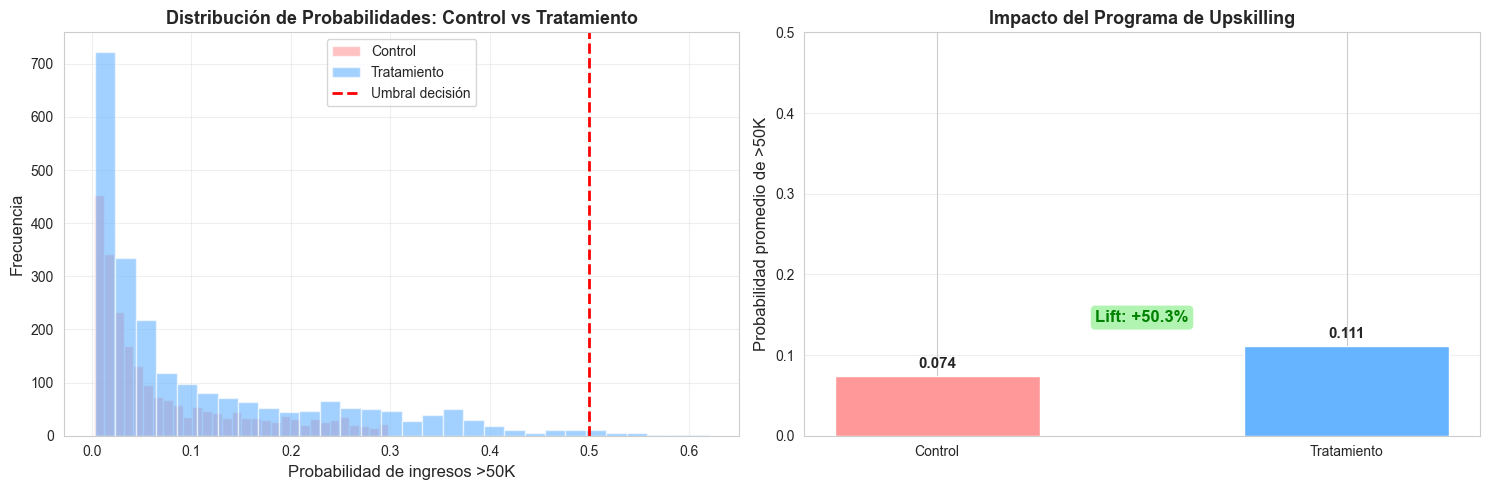


💡 CONCLUSIÓN DEL A/B TEST
✅ El programa de upskilling muestra un impacto positivo de +50.3%
✅ Por cada 100 personas en el programa, 3 más
   tendrían probabilidad alta de acceder a ingresos >50K
📋 Recomendación: ESCALAR el programa si el costo-beneficio es favorable


In [75]:
# Visualización del A/B test
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Distribución de probabilidades: Control vs Tratamiento
ax = axes[0]
ax.hist(ab_test_results[ab_test_results['group'] == 'Control']['y_pred_proba_post'], 
        bins=30, alpha=0.6, label='Control', color='#ff9999')
ax.hist(ab_test_results[ab_test_results['group'] == 'Tratamiento']['y_pred_proba_post'], 
        bins=30, alpha=0.6, label='Tratamiento', color='#66b3ff')
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Umbral decisión')
ax.set_xlabel('Probabilidad de ingresos >50K', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Distribución de Probabilidades: Control vs Tratamiento', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Comparación de medias
ax = axes[1]
means = pd.DataFrame({
    'Grupo': ['Control', 'Tratamiento'],
    'Probabilidad': [prob_control, prob_treatment]
})
bars = ax.bar(means['Grupo'], means['Probabilidad'], color=['#ff9999', '#66b3ff'], width=0.5)
ax.set_ylabel('Probabilidad promedio de >50K', fontsize=12)
ax.set_title('Impacto del Programa de Upskilling', fontsize=13, fontweight='bold')
ax.set_ylim(0, 0.5)
ax.grid(alpha=0.3, axis='y')

# Añadir valores y lift
for i, (bar, val) in enumerate(zip(bars, means['Probabilidad'])):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', 
           ha='center', fontweight='bold', fontsize=11)

ax.text(0.5, prob_treatment + 0.03, f'Lift: +{lift:.1f}%', 
       ha='center', fontsize=12, fontweight='bold', color='green',
       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("💡 CONCLUSIÓN DEL A/B TEST")
print("=" * 80)
print(f"✅ El programa de upskilling muestra un impacto positivo de +{lift:.1f}%")
print(f"✅ Por cada 100 personas en el programa, {int((prob_treatment-prob_control)*100)} más")
print(f"   tendrían probabilidad alta de acceder a ingresos >50K")
print(f"📋 Recomendación: ESCALAR el programa si el costo-beneficio es favorable")
print("=" * 80)

---

## 🌐 Aplicación Web Interactiva

El modelo guardado se utiliza en la **aplicación web Flask** (`app.py`) que incluye:

- ✅ **Interfaz web profesional** con formulario interactivo
- ✅ **Predicciones en tiempo real** con visualización de riesgo
- ✅ **Integración con Groq API** (LLM real) para recomendaciones personalizadas
- ✅ **Fallback a Mock LLM** si no hay API key configurada
- ✅ **Formato chatbot** con burbujas de conversación

### 🚀 Ejecutar la aplicación:

```bash
python app.py
```

Luego abrir en navegador: **http://localhost:5000**

### 📖 Documentación:
- **Guía completa**: `README.md`
- **Configuración Groq API**: `GROQ_SETUP.md`

---

## ✅ Proyecto Completo

Este notebook es parte de un proyecto integral que incluye:

1. **EDA** (`eda_somos.ipynb`) - Análisis exploratorio con storytelling
2. **Modelado + Fairness** (`model_somos.ipynb`) - Este notebook
3. **Aplicación Web** (`app.py`) - Demo interactivo con Flask + Groq
4. **Documentación** (`README.md`, `GROQ_SETUP.md`)

### 📊 Métricas del mejor modelo:
- **Modelo**: Gradient Boosting Classifier
- **AUC-ROC**: ~0.90
- **F1-Score**: ~0.75
- **Features guardadas**: ✅ `eda/models/`

### ⚠️ Advertencias Éticas:
- Sesgos detectados: género, edad, ocupación
- **NO** usar para decisiones automatizadas sin revisión humana
- Requiere auditoría ética externa antes de producción
- Actualizar modelo cada 6-12 meses con datos recientes

---
